In [2]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv
Saving test.csv to test.csv


In [14]:
%matplotlib inline
import numpy as np
from numpy import array
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

Instructions for updating:
non-resource variables are not supported in the long term


In [15]:

LABELS = 10 # Number of different types of labels (1-10)
WIDTH = 28 # width / height of the image
CHANNELS = 1 # Number of colors in the image (greyscale)

VALID = 1000 # Validation data size

STEPS = 8000# Number of steps to run
BATCH = 32 # Stochastic Gradient Descent batch size
PATCH = 5 # Convolutional Kernel size
DEPTH = 32 #32 # Convolutional Kernel depth size == Number of Convolutional Kernels
HIDDEN = 1024 #1024 # Number of hidden neurons in the fully connected layer

LR = 0.0013 # Learning rate

In [16]:
data = pd.read_csv('train.csv') # Read csv file in pandas dataframe
labels = np.array(data.pop('label')) # Remove the labels as a numpy array from the dataframe
labels = LabelEncoder().fit_transform(labels)[:, None]
labels = OneHotEncoder().fit_transform(labels).todense()
data = StandardScaler().fit_transform(np.float32(data.values)) # Convert the dataframe to a numpy array
data = data.reshape(-1, WIDTH, WIDTH, CHANNELS) # Reshape the data into 42000 2d images
train_data, valid_data = data[:-VALID], data[-VALID:]
train_labels, valid_labels = labels[:-VALID], labels[-VALID:]

print('train data shape = ' + str(train_data.shape) + ' = (TRAIN, WIDTH, WIDTH, CHANNELS)')
print('labels shape = ' + str(labels.shape) + ' = (TRAIN, LABELS)')

train data shape = (41000, 28, 28, 1) = (TRAIN, WIDTH, WIDTH, CHANNELS)
labels shape = (42000, 10) = (TRAIN, LABELS)


In [17]:
tf_data = tf.placeholder(tf.float32, shape=(None, WIDTH, WIDTH, CHANNELS))
tf_labels = tf.placeholder(tf.float32, shape=(None, LABELS))

In [18]:

w1 = tf.Variable(tf.truncated_normal([PATCH, PATCH, CHANNELS, DEPTH], stddev=0.1))
b1 = tf.Variable(tf.zeros([DEPTH]))
w2 = tf.Variable(tf.truncated_normal([PATCH, PATCH, DEPTH, 2*DEPTH], stddev=0.1))
b2 = tf.Variable(tf.constant(1.0, shape=[2*DEPTH]))
w3 = tf.Variable(tf.truncated_normal([WIDTH // 4 * WIDTH // 4 * 2*DEPTH, HIDDEN], stddev=0.1))
b3 = tf.Variable(tf.constant(1.0, shape=[HIDDEN]))
w4 = tf.Variable(tf.truncated_normal([HIDDEN, LABELS], stddev=0.1))
b4 = tf.Variable(tf.constant(1.0, shape=[LABELS]))

def logits(data):
    # Convolutional layer 1
    x = tf.nn.conv2d(data, w1, [1, 1, 1, 1], padding='SAME')
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    x = tf.nn.relu(x + b1)
    # Convolutional layer 2
    x = tf.nn.conv2d(x, w2, [1, 1, 1, 1], padding='SAME')
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    x = tf.nn.relu(x + b2)
    # Fully connected layer
    x = tf.reshape(x, (-1, WIDTH // 4 * WIDTH // 4 * 2*DEPTH))
    x = tf.nn.relu(tf.matmul(x, w3) + b3)
    return tf.matmul(x, w4) + b4

# Prediction:
tf_pred = tf.nn.softmax(logits(tf_data))

In [19]:
tf_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits(tf_data), 
                                                                 labels=tf_labels))
tf_acc = 100*tf.reduce_mean(tf.to_float(tf.equal(tf.argmax(tf_pred, 1), tf.argmax(tf_labels, 1))))

#tf_opt = tf.train.GradientDescentOptimizer(LR)
#tf_opt = tf.train.AdamOptimizer(LR)
tf_opt = tf.train.RMSPropOptimizer(LR)
tf_step = tf_opt.minimize(tf_loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [20]:

init = tf.global_variables_initializer()
session = tf.Session()
session.run(init)

In [21]:

train_data[4].shape

(28, 28, 1)

In [22]:
ss = ShuffleSplit(n_splits=STEPS, train_size=BATCH)
ss.get_n_splits(train_data, train_labels)
history = [(0, np.nan, 10)] # Initial Error Measures
for step, (idx, _) in enumerate(ss.split(train_data,train_labels), start=1):
    fd = {tf_data:train_data[idx], tf_labels:train_labels[idx]}
    session.run(tf_step, feed_dict=fd)
    if step%500 == 0:
        fd = {tf_data:valid_data, tf_labels:valid_labels}
        valid_loss, valid_accuracy = session.run([tf_loss, tf_acc], feed_dict=fd)
        history.append((step, valid_loss, valid_accuracy))
        print('Step %i \t Valid. Acc. = %f \n'%(step, valid_accuracy))

Step 500 	 Valid. Acc. = 93.900002 

Step 1000 	 Valid. Acc. = 96.800003 

Step 1500 	 Valid. Acc. = 97.599998 

Step 2000 	 Valid. Acc. = 97.099998 

Step 2500 	 Valid. Acc. = 95.800003 

Step 3000 	 Valid. Acc. = 97.599998 

Step 3500 	 Valid. Acc. = 98.299995 

Step 4000 	 Valid. Acc. = 98.099998 

Step 4500 	 Valid. Acc. = 98.400002 

Step 5000 	 Valid. Acc. = 97.299995 

Step 5500 	 Valid. Acc. = 97.199997 

Step 6000 	 Valid. Acc. = 98.299995 

Step 6500 	 Valid. Acc. = 98.599998 

Step 7000 	 Valid. Acc. = 97.500000 

Step 7500 	 Valid. Acc. = 98.699997 

Step 8000 	 Valid. Acc. = 98.199997 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


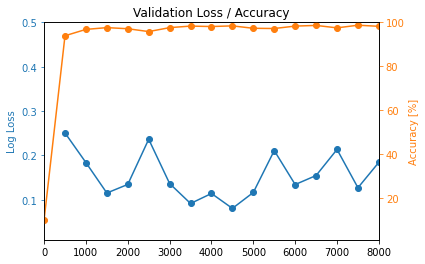

In [23]:
steps, loss, acc = zip(*history)

fig = plt.figure()
plt.title('Validation Loss / Accuracy')
ax_loss = fig.add_subplot(111)
ax_acc = ax_loss.twinx()
plt.xlabel('Training Steps')
plt.xlim(0, max(steps))

ax_loss.plot(steps, loss, '-o', color='C0')
ax_loss.set_ylabel('Log Loss', color='C0');
ax_loss.tick_params('y', colors='C0')
ax_loss.set_ylim(0.01, 0.5)

ax_acc.plot(steps, acc, '-o', color='C1')
ax_acc.set_ylabel('Accuracy [%]', color='C1');
ax_acc.tick_params('y', colors='C1')
ax_acc.set_ylim(1,100)

plt.show()

In [24]:

test = pd.read_csv('test.csv') # Read csv file in pandas dataframe
test.info()
test_data = StandardScaler().fit_transform(np.float32(test.values)) # Convert the dataframe to a numpy array
test_data = test_data.reshape(-1, WIDTH, WIDTH, CHANNELS) # Reshape the data into 42000 2d images

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [26]:

print (test_data.shape)
test_labels = []

(28000, 28, 28, 1)


In [27]:
ss = ShuffleSplit(n_splits=28000, train_size=BATCH)
ss.get_n_splits(test_data)
for (idx, _) in enumerate(ss.split(test_data), start=0):
    temp_test_data = array(test_data[idx]).reshape(1, 28, 28, 1)
    fd = {tf_data: temp_test_data}
    test_pred = session.run(tf_pred, feed_dict=fd)
    temp = np.argmax(test_pred, axis=1)
    test_labels.append(temp)

In [29]:
print (len(test_labels))

28000


In [30]:
#test_labels = np.array(test_labels)
#test labels = np.delete(test_labels,(0),axis=0)
#test_labels.shape[0]

Label Prediction: 0


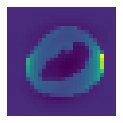

In [34]:
k = 1283 # Try different image indices k
print("Label Prediction: %i"%test_labels[k])
fig = plt.figure(figsize=(2,2)); plt.axis('off')
plt.imshow(test_data[k,:,:,0]); plt.show()

In [35]:

for i in range(len(test_labels)):
    test_labels[i] = int(test_labels[i])